In [1]:
import GPy
import numpy as np
import pygmo as pg
import scipy
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def MU(model,xa):
    K = model.kern.K(model.X,model.X)
    L = np.linalg.cholesky(K + (0.1**2.0)*np.eye(len(K)))
    Lk = np.linalg.solve(L, model.kern.K(model.X, xa))
    mu = np.dot(Lk.T, np.linalg.solve(L, model.Y))
    return mu

def COV(model,xa1,xa2):
    K = model.kern.K(model.X,model.X)
    L = np.linalg.cholesky(K + (0.1**2.0)*np.eye(len(K)))
    Lk1 = np.linalg.solve(L, model.kern.K(model.X, xa1))
    Lk2 = np.linalg.solve(L, model.kern.K(model.X, xa2))
    K_ = model.kern.K(xa1, xa2)
    s2 = np.matrix(K_) - np.matrix(np.dot(Lk2.T,Lk1))
    return s2

def COV1(model,xa1):
    K = model.kern.K(model.X,model.X)
    L = np.linalg.cholesky(K + (0.1**2.0)*np.eye(len(K)))
    Lk = np.linalg.solve(L, model.kern.K(model.X, xa1))
    K_ = model.kern.K(xa1, xa1)
    s2 = K_ - np.sum(Lk**2, axis=0)
    return s2
 
def true_Q(a):
    X = lhs(1, samples=1000)*100
    xa = [[i,a] for val in X for i in val]
    F_a = np.sum(test_func(xa, NoiseSD=0))
    return F_a

def predic_Q(a,model,Nx):
    X = lhs(1, samples=1000)*100
    xa = [[i,a] for val in X for i in val]
    F_x = np.mean(model.predict(np.array(xa))[0])
    return F_x

def SUM_MU(X,a,model,Nx):
    xa = [[i,a] for val in X for i in val]
    F_a = np.sum(model.predict(np.array(xa))[0])
    return F_a

def SUM_COV(a,xan,model,Nx):
    X = lhs(1, samples=Nx)*100
    xa = [[i,a] for val in X for i in val]
    COV = [model.kern.K(np.array([i]),np.array([xan])) for i in xa]
    SUM_COV = np.sum(COV)
    return SUM_COV


In [3]:
def latexify(fig_width=None, fig_height=None, columns=1):
    """Set up matplotlib's RC params for LaTeX plotting.
    Call this before plotting a figure.

    Parameters
    ----------
    fig_width : float, optional, inches
    fig_height : float,  optional, inches
    columns : {1, 2}
    """

    # code adapted from http://www.scipy.org/Cookbook/Matplotlib/LaTeX_Examples

    # Width and max height in inches for IEEE journals taken from
    # computer.org/cms/Computer.org/Journal%20templates/transactions_art_guide.pdf

    assert(columns in [1,2])

    if fig_width is None:
        fig_width = 3.39 if columns==1 else 6.9 # width in inches

    if fig_height is None:
        golden_mean = (sqrt(5)-1.0)/2.0    # Aesthetic ratio
        fig_height = fig_width*golden_mean # height in inches

    MAX_HEIGHT_INCHES = 8.5
    if fig_height > MAX_HEIGHT_INCHES:
        print("WARNING: fig_height too large:" + fig_height + 
              "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
        fig_height = MAX_HEIGHT_INCHES

    params = {'backend': 'ps',
              'text.latex.preamble': ['\usepackage{gensymb}'],
              'axes.labelsize': 20, # fontsize for x and y labels (was 10)
              'axes.titlesize': 20,
              'text.fontsize': 20, # was 10
              'legend.fontsize': 20, # was 10
              'xtick.labelsize': 20,
              'ytick.labelsize': 20,
              'text.usetex': True,
              'figure.figsize': [fig_width,fig_height],
              'font.family': 'serif'
    }

    matplotlib.rcParams.update(params)


def format_axes(ax):

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    for spine in ['left', 'bottom']:
        ax.spines[spine].set_color(SPINE_COLOR)
        ax.spines[spine].set_linewidth(0.5)

    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_tick_params(direction='out', color=SPINE_COLOR)

    return ax
import matplotlib
latexify(fig_width=6, fig_height=4)

 /home/juan/.local/lib/python2.7/site-packages/matplotlib/__init__.py:913: UserWarning:text.fontsize is deprecated and replaced with font.size; please use the latter.


In [208]:
n=1
X = np.random.uniform(-5,5,(n,1))
Y = np.sin(0.9*X) + np.random.normal(0,np.sqrt(0.01),(n,1))
kernel = GPy.kern.RBF(input_dim=1, variance=1, lengthscale=10)
m1 = GPy.models.GPRegression(X,Y,kernel,noise_var=0.)
m1.optimize_restarts(num_restarts = 16)

Optimization restart 1/16, f = 1.11880951948
Optimization restart 2/16, f = 0.960470521728
Optimization restart 3/16, f = 0.960470521425
Optimization restart 4/16, f = 0.960470521534
Optimization restart 5/16, f = 0.960470521607
Optimization restart 6/16, f = 0.960470521369
Optimization restart 7/16, f = 0.960470521369
Optimization restart 8/16, f = 0.960470521368
Optimization restart 9/16, f = 0.960470521377
Optimization restart 10/16, f = 0.960470521368
Optimization restart 11/16, f = 0.960470521456
Optimization restart 12/16, f = 0.960470521384
Optimization restart 13/16, f = 0.960470521505
Optimization restart 14/16, f = 0.960470521385
Optimization restart 15/16, f = 0.960470521369
Optimization restart 16/16, f = 0.960470521368


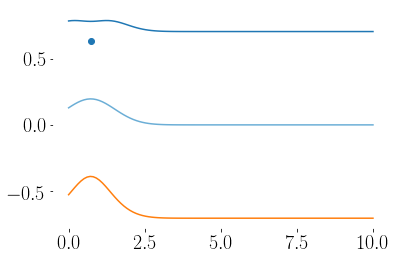

In [209]:
X0 = np.linspace(0,10,100)
P,SS = m1.predict(np.array([X0]).T,include_likelihood=False )
plt.plot(X0,P, color=(107.0/255,174/255.0,214/255.0))
plt.plot(X0,P+2*np.sqrt(SS))
plt.plot(X0,P-2*np.sqrt(SS))
plt.scatter(X,Y)
plt.show()

In [6]:
X

array([[2.22260183]])

In [7]:
Y

array([[0.84185781]])

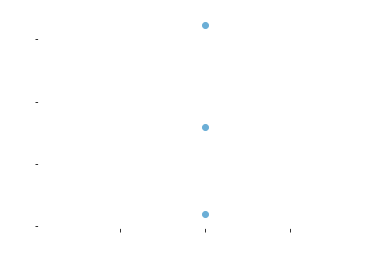

In [97]:
X = np.array([0.5])
Y = np.random.random(3)

matplotlib.rc('axes',edgecolor='white')
plt.tick_params(axis='y', labelcolor='white')
plt.tick_params(axis='x', labelcolor='white')
plt.scatter(np.repeat(X,len(Y)),Y,color=(107.0/255,174/255.0,214/255.0))
plt.savefig('/home/juan/Downloads/Individual_Project/Presentation/Presentation_plot_1.eps', eps=1000,bbox_inches='tight',transparent=True)
plt.show()

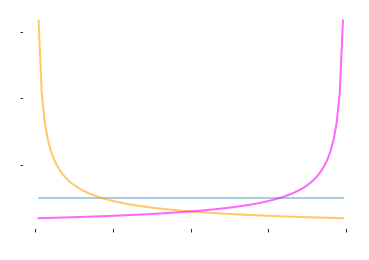

In [76]:
from scipy.stats import beta
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
a, b = 1, 1
c,d =0.4,1
e,f =1,0.4
x = np.linspace(beta.ppf(0.01, a, b),beta.ppf(0.99, a, b), 100)
ax.plot(x, beta.pdf(x, a, b),'r-', lw=2, alpha=0.6 ,color=(107.0/255,174/255.0,214/255.0))
ax.plot(x, beta.pdf(x, c, d),'r-', lw=2, alpha=0.6 ,color='orange')
ax.plot(x, beta.pdf(x, e, f),'r-', lw=2, alpha=0.6 ,color='magenta')
plt.tick_params(axis='y', labelcolor='white')
plt.tick_params(axis='x', labelcolor='white')
plt.savefig('/home/juan/Downloads/Individual_Project/Presentation/Presentation_plot_2.eps', eps=1000,bbox_inches='tight',transparent=True,alpha=1.0)
plt.show()

In [77]:
def draw_gaussian_at(support, sd=1.0, height=1.0, 
        xpos=0.0, ypos=0.0, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()
    gaussian = np.exp((-support ** 2.0) / (2 * sd ** 2.0))
    gaussian /= gaussian.max()
    gaussian *= -height
    return ax.plot(gaussian + xpos, support + ypos, **kwargs)

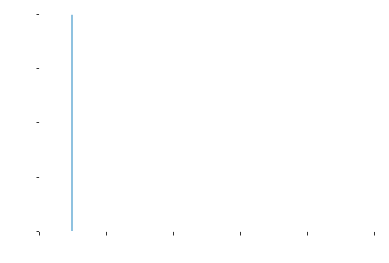

In [78]:
support = np.linspace(-2, 2, 1000)
fig, ax = plt.subplots()
matplotlib.rc('axes',edgecolor='white')
plt.tick_params(axis='y', labelcolor='white')
plt.tick_params(axis='x', labelcolor='white')
plt.xlim((0,10))
plt.ylim((-4,4))
for each in np.linspace(1, 10, 1):
    x_point = each
    y_point = np.array([-4,4])
    ax.plot(np.repeat(x_point,len(y_point)),y_point,color=(107.0/255,174/255.0,214/255.0) )
    #draw_gaussian_at(support, sd=0.5, height=-0.5, xpos=each, ypos=0.0, ax=ax, color='orange')
    
plt.savefig('/home/juan/Downloads/Individual_Project/Presentation/Presentation_plot_3.eps', eps=1000,bbox_inches='tight',transparent=True,alpha=1.0)

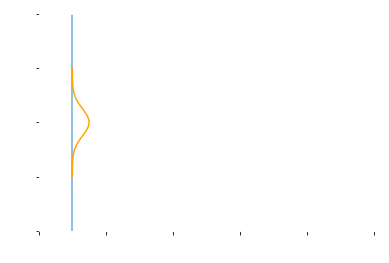

In [79]:
support = np.linspace(-2, 2, 1000)
fig, ax = plt.subplots()
ax.tick_params(axis='y', labelcolor='white')
ax.tick_params(axis='x', labelcolor='white')
plt.xlim((0,10))
plt.ylim((-4,4))
for each in np.linspace(1, 10, 1):
    x_point = each
    y_point = np.array([-4,4])
    ax.plot(np.repeat(x_point,len(y_point)),y_point,color=(107.0/255,174/255.0,214/255.0) )
    draw_gaussian_at(support, sd=0.5, height=-0.5, xpos=each, ypos=0.0, ax=ax, color='orange')
    
plt.savefig('/home/juan/Downloads/Individual_Project/Presentation/Presentation_plot_4.eps', eps=1000,bbox_inches='tight',transparent=True,alpha=1.0)

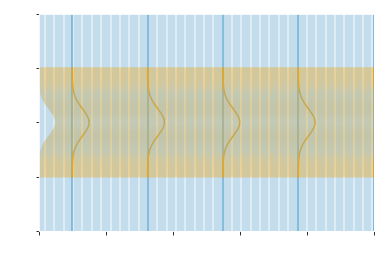

In [80]:
support = np.linspace(-2, 2, 1000)
fig, ax = plt.subplots()
ax.tick_params(axis='y', labelcolor='white')
ax.tick_params(axis='x', labelcolor='white')
plt.xlim((0,10))
plt.ylim((-4,4))
for each in np.linspace(1, 10, 5):
    x_point = each
    y_point = np.array([-4,4])
    ax.plot(np.repeat(x_point,len(y_point)),y_point,color=(107.0/255,174/255.0,214/255.0) )
    draw_gaussian_at(support, sd=0.5, height=-0.5, xpos=each, ypos=0.0, ax=ax, color='orange')
    
plt.savefig('/home/juan/Downloads/Individual_Project/Presentation/Presentation_plot_5.eps', eps=1000,bbox_inches='tight',transparent=True,alpha=1.0)

for each in np.linspace(0, 10, 300):
    x_point = each
    y_point = np.array([-4,4])
    ax.plot(np.repeat(x_point,len(y_point)),y_point,color=(107.0/255,174/255.0,214/255.0),alpha=0.3)
    draw_gaussian_at(support, sd=0.5, height=-0.5, xpos=each, ypos=0.0, ax=ax, color='orange',alpha=0.3)
    
plt.savefig('/home/juan/Downloads/Individual_Project/Presentation/Presentation_plot_6.pdf', eps=1000,bbox_inches='tight',transparent=True)

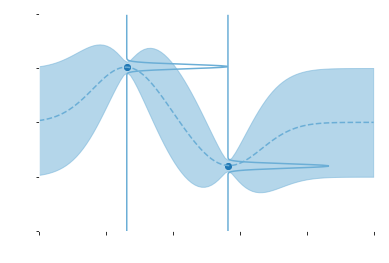

In [108]:
support = np.linspace(-10, 10, 1000)
fig, ax = plt.subplots()
ax.tick_params(axis='y', labelcolor='white')
ax.tick_params(axis='x', labelcolor='white')
plt.xlim((0,10))
plt.ylim((-4,4))
H = []
for each in np.random.random(2)*7:
    x_point = each
    y_point = np.array([-4,4])
    
    y_fit = np.random.random()*8 -4
    H.append([x_point,y_fit])
    ax.scatter(x_point,y_fit,color=(107.0/255,174/255.0,214/255.0))
    #ax.plot(np.repeat(x_point,len(y_point)),y_point,color=(107.0/255,174/255.0,214/255.0) )
    draw_gaussian_at(support, sd=0.08, height=-3, xpos=each, ypos=y_fit, ax=ax, color=(107.0/255,174/255.0,214/255.0) )
    
plt.savefig('/home/juan/Downloads/Individual_Project/Presentation/Presentation_plot_7.eps', eps=1000,bbox_inches='tight',transparent=True,alpha=1.0)
X = np.array(H)[:,0]
Y = np.array(H)[:,1]
kernel = GPy.kern.RBF(input_dim=1, variance=1, lengthscale=1)
m1 = GPy.models.GPRegression(np.array([X]).T,np.array([Y]).T,kernel,noise_var=0.0)
m1.Gaussian_noise.variance =0.01

X0 = np.linspace(0,10,100)
P,SS = m1.predict(np.array([X0]).T,include_likelihood=False)
plt.plot(X0,P, color=(107.0/255,174/255.0,214/255.0),linestyle='dashed')
plt.fill_between(X0,(P-2*np.sqrt(SS)).T[0],(P+2*np.sqrt(SS)).T[0],color=(107.0/255,174/255.0,214/255.0),alpha=0.5)
plt.scatter(X,Y)

plt.savefig('/home/juan/Downloads/Individual_Project/Presentation/Presentation_plot_8.pdf', eps=1000,bbox_inches='tight',transparent=True,alpha=1.0)

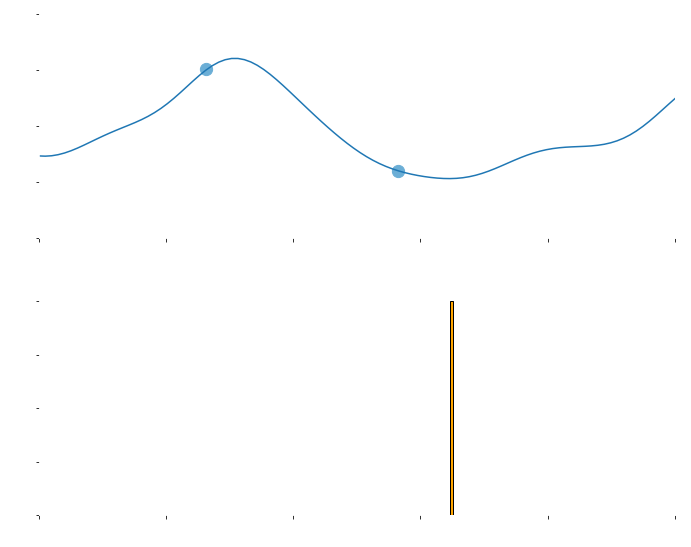

In [109]:

fig, axs = plt.subplots(2, 1, sharex=True,figsize=(10, 10), tight_layout=True)
axs[0].tick_params(axis='y', labelcolor='white')
axs[0].tick_params(axis='x', labelcolor='white')
axs[1].tick_params(axis='y', labelcolor='white')
axs[1].tick_params(axis='x', labelcolor='white')
Xnew = np.linspace(0, 10, 100)[:, None]
# Get mean and covariance of optimised GP
mean, Cov = m1.predict_noiseless(Xnew, full_cov=True)

axs[0].set_xlim((0,10))
axs[0].set_ylim((-4,4))
#X0 = np.linspace(0,10,100)
#P,SS = m1.predict(np.array([X0]).T,include_likelihood=False)

Z = np.random.multivariate_normal(mean[:,0], Cov, 1)
#plt.plot(X0,P, color=(107.0/255,174/255.0,214/255.0),linestyle='dashed')
#plt.fill_between(X0,(P-2*np.sqrt(SS)).T[0],(P+2*np.sqrt(SS)).T[0],color=(107.0/255,174/255.0,214/255.0),alpha=0.5)

axs[0].plot(Xnew,Z.T)    
axs[0].scatter(X,Y,color = (107.0/255,174/255.0,214/255.0),s=150)

MN = Xnew[np.argmin(Z,axis=1)]
fig.set_figheight(8)
axs[1].set_title('Histogram over the minimum',color='white')
axs[1].hist(MN,bins=20,normed=True,histtype='bar', ec='black',color='orange')
plt.savefig('/home/juan/Downloads/Individual_Project/Presentation/Presentation_plot_9.pdf', eps=1000,bbox_inches='tight',transparent=True,alpha=1.0)

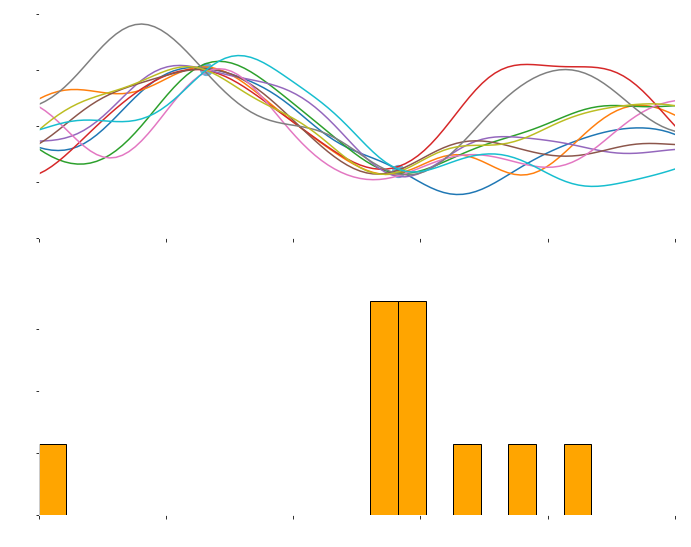

In [112]:

fig, axs = plt.subplots(2, 1, sharex=True,figsize=(10, 10), tight_layout=True)

axs[0].tick_params(axis='y', labelcolor='white')
axs[0].tick_params(axis='x', labelcolor='white')
axs[1].tick_params(axis='y', labelcolor='white')
axs[1].tick_params(axis='x', labelcolor='white')

Xnew = np.linspace(0, 10, 100)[:, None]
# Get mean and covariance of optimised GP
mean, Cov = m1.predict_noiseless(Xnew, full_cov=True)

axs[0].set_xlim((0,10))
axs[0].set_ylim((-4,4))
#X0 = np.linspace(0,10,100)
#P,SS = m1.predict(np.array([X0]).T,include_likelihood=False)

Z = np.random.multivariate_normal(mean[:,0], Cov, 10)
#plt.plot(X0,P, color=(107.0/255,174/255.0,214/255.0),linestyle='dashed')
#plt.fill_between(X0,(P-2*np.sqrt(SS)).T[0],(P+2*np.sqrt(SS)).T[0],color=(107.0/255,174/255.0,214/255.0),alpha=0.5)

axs[0].plot(Xnew,Z.T)    
axs[0].scatter(X,Y,color = (107.0/255,174/255.0,214/255.0),s=150)

MN = Xnew[np.argmin(Z,axis=1)]
fig.set_figheight(8)
axs[1].set_title('Histogram over the minimum',color='white')
axs[1].hist(MN,bins=20,normed=True,histtype='bar', ec='black',color='orange')
plt.savefig('/home/juan/Downloads/Individual_Project/Presentation/Presentation_plot_10.pdf', eps=1000,bbox_inches='tight',transparent=True,alpha=1.0)

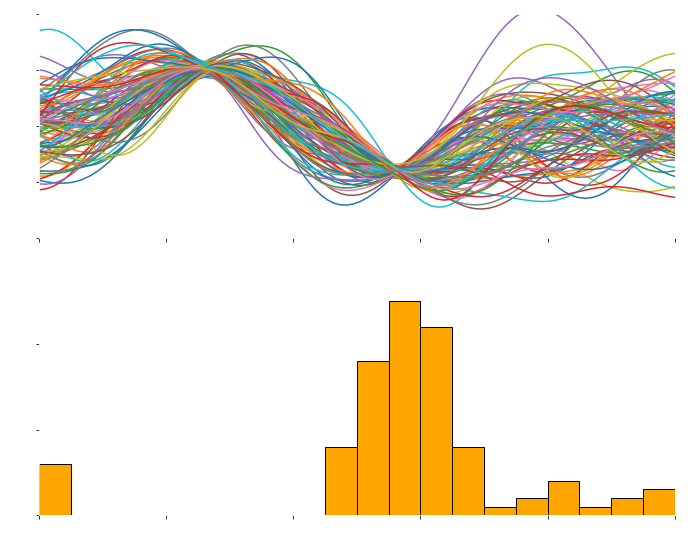

In [113]:

fig, axs = plt.subplots(2, 1, sharex=True,figsize=(10, 10), tight_layout=True)
axs[0].tick_params(axis='y', labelcolor='white')
axs[0].tick_params(axis='x', labelcolor='white')
axs[1].tick_params(axis='y', labelcolor='white')
axs[1].tick_params(axis='x', labelcolor='white')

Xnew = np.linspace(0, 10, 100)[:, None]
# Get mean and covariance of optimised GP
mean, Cov = m1.predict_noiseless(Xnew, full_cov=True)

axs[0].set_xlim((0,10))
axs[0].set_ylim((-4,4))
#X0 = np.linspace(0,10,100)
#P,SS = m1.predict(np.array([X0]).T,include_likelihood=False)

Z = np.random.multivariate_normal(mean[:,0], Cov, 100)
#plt.plot(X0,P, color=(107.0/255,174/255.0,214/255.0),linestyle='dashed')
#plt.fill_between(X0,(P-2*np.sqrt(SS)).T[0],(P+2*np.sqrt(SS)).T[0],color=(107.0/255,174/255.0,214/255.0),alpha=0.5)

axs[0].plot(Xnew,Z.T)    
axs[0].scatter(X,Y,color = (107.0/255,174/255.0,214/255.0),s=150)
#axs[0].scatter(X,Y,color = (250.0/255,128/255.0,114/255.0),s=150)

MN = Xnew[np.argmin(Z,axis=1)]
fig.set_figheight(8)
axs[1].set_title('Histogram over the minimum',color='white')
axs[1].hist(MN,bins=20,normed=True,histtype='bar', ec='black',color='orange')
#plt.plot(axs[1].hist(MN,bins=20,normed=True)[1],axs[1].hist(MN,bins=20,normed=True)[0])
plt.savefig('/home/juan/Downloads/Individual_Project/Presentation/Presentation_plot_11.pdf', eps=1000,bbox_inches='tight',transparent=True,alpha=1.0)